In [70]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets
customers_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagements_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

## DATA CLEANING

# Convert date columns to datetime
customers_df['join_date'] = pd.to_datetime(customers_df['join_date'])
customers_df['last_purchase_date'] = pd.to_datetime(customers_df['last_purchase_date'])
marketing_df['campaign_date'] = pd.to_datetime(marketing_df['campaign_date'])
transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])

# Define the cutoff date
cutoff_date = pd.to_datetime('2024-05-31')

# Convert dates later than 5/31/2024 to 5/31/2024
customers_df['join_date'] = customers_df['join_date'].apply(lambda x: x if x <= cutoff_date else cutoff_date)
customers_df['last_purchase_date'] = customers_df['last_purchase_date'].apply(lambda x: x if x <= cutoff_date else cutoff_date)
marketing_df['campaign_date'] = marketing_df['campaign_date'].apply(lambda x: x if x <= cutoff_date else cutoff_date)
transactions_df['transaction_date'] = transactions_df['transaction_date'].apply(lambda x: x if x <= cutoff_date else cutoff_date)

# Merging
# Aggregate marketing responses
marketing_agg = marketing_df.groupby('customer_id')['response'].value_counts().unstack(fill_value=0).reset_index()
marketing_agg.columns = ['customer_id', 'no_response', 'yes_response']

# Aggregate transaction data
transactions_agg = transactions_df.groupby('customer_id').agg(
    total_transaction_amount=pd.NamedAgg(column='transaction_amount', aggfunc='sum'),
    number_of_transactions=pd.NamedAgg(column='transaction_id', aggfunc='count')
).reset_index()

# Merge all dataframes
merged_df = customers_df.merge(engagements_df, on='customer_id', how='left') \
                        .merge(marketing_agg, on='customer_id', how='left') \
                        .merge(transactions_agg, on='customer_id', how='left')

# Fill NaN values for no_response and yes_response with 0
merged_df['no_response'] = merged_df['no_response'].fillna(0)
merged_df['yes_response'] = merged_df['yes_response'].fillna(0)

# Fill NaN values for total_transaction_amount and number_of_transactions with 0
merged_df['total_transaction_amount'] = merged_df['total_transaction_amount'].fillna(0)
merged_df['number_of_transactions'] = merged_df['number_of_transactions'].fillna(0)

# Impute 'Unknown' for missing gender values
merged_df['gender'] = merged_df['gender'].fillna('Unknown')

# Impute missing age with KNNImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# Convert date columns to numeric
merged_df['join_date_numeric'] = merged_df['join_date'].astype('int64') // 10**9
merged_df['last_purchase_date_numeric'] = merged_df['last_purchase_date'].astype('int64') // 10**9

# Encode categorical variables
le_gender = LabelEncoder()
merged_df['gender_encoded'] = le_gender.fit_transform(merged_df['gender'])

le_location = LabelEncoder()
merged_df['location_encoded'] = le_location.fit_transform(merged_df['location'])

# Prepare data for KNN imputation
impute_cols = ['age', 'join_date_numeric', 'last_purchase_date_numeric', 'gender_encoded', 'location_encoded']
impute_data = merged_df[impute_cols]

# Perform KNN imputation
knn_imputer = KNNImputer(n_neighbors=5)
imputed_data = knn_imputer.fit_transform(impute_data)

# Assign imputed age values back to the dataframe
merged_df['age'] = imputed_data[:, 0]

# Drop intermediate columns
merged_df = merged_df.drop(columns=['join_date_numeric', 'last_purchase_date_numeric', 'gender_encoded', 'location_encoded'])

## Feature Engineering

# Calculate Recency, Frequency, and Monetary (clv_monthly) Value (RFM) features
import numpy as np

# Define the cutoff date
cutoff_date = pd.to_datetime('2024-05-31')

# Calculate the joined month
merged_df['joined_month'] = ((cutoff_date - merged_df['join_date']).dt.days / 30).astype(int)
merged_df['joined_month'] = merged_df['joined_month'].apply(lambda x: 1 if x == 0 else x)

# Calculate Recency (in months)
merged_df['recency_months'] = (( merged_df['last_purchase_date'] - cutoff_date).dt.days / 30).astype(int)

# Calculate Frequency
merged_df['frequency'] = merged_df['number_of_transactions']

# Calculate Monetary Value (transaction value per month, clv_monthly)
merged_df['clv'] = merged_df['total_transaction_amount']
merged_df['clv_monthly'] = merged_df['clv'] / merged_df['joined_month']

# Fill any NaN values resulting from zero transactions or other calculations
merged_df['recency_months'] = merged_df['recency_months'].fillna(0)
merged_df['frequency'] = merged_df['frequency'].fillna(0)
merged_df['clv_monthly'] = merged_df['clv_monthly'].fillna(0)

# For marketing and engagement data
# Calculate the number of 'yes_response' per month
merged_df['yes_response_per_month'] = merged_df['yes_response'] / merged_df['joined_month']

# Calculate the number of 'no_response' per month
merged_df['no_response_per_month'] = merged_df['no_response'] / merged_df['joined_month']

# Calculate the number of site visits per month
merged_df['site_visits_per_month'] = merged_df['number_of_site_visits'] / merged_df['joined_month']

# Calculate the number of emails opened per month
merged_df['emails_opened_per_month'] = merged_df['number_of_emails_opened'] / merged_df['joined_month']

# Calculate the number of clicks per month
merged_df['clicks_per_month'] = merged_df['number_of_clicks'] / merged_df['joined_month']

# use the 80-20 rule, sorting the customer with clv_monthly
# labelling the highest clv_monthly customers who cumulatively contribute 80% of the total monthly clv as 'High-Value'
# other as ‘Low-Value’

# Calculate the cumulative contribution of each customer to the total monthly CLV
merged_df = merged_df.sort_values(by='clv_monthly', ascending=False)
merged_df['cumulative_clv'] = merged_df['clv_monthly'].cumsum()
total_clv = merged_df['clv_monthly'].sum()
merged_df['cumulative_clv_percentage'] = merged_df['cumulative_clv'] / total_clv

# Label customers based on their contribution to the total monthly CLV
merged_df['value_label'] = np.where(merged_df['cumulative_clv_percentage'] <= 0.80, 'High-Value', 'Low-Value')

# Convert CLV_label to binary
merged_df['value_label'] = np.where(merged_df['value_label'] == 'High-Value', 1, 0)

# Drop intermediate columns
merged_df = merged_df.drop(columns=['cumulative_clv', 'cumulative_clv_percentage'])

In [61]:
## EDA

In [62]:
# Check the imbalance
# Calculate the distribution of the target variable
class_distribution = merged_df['value_label'].value_counts(normalize=True)

# Print the class distribution
print(class_distribution)

value_label
0    0.728
1    0.272
Name: proportion, dtype: float64


In [63]:
# age-clv analysis
# Define age groups
bins = [0, 20, 40, 60, np.inf]
labels = ['<20', '20-40', '40-60', '>60']
merged_df['age_group'] = pd.cut(merged_df['age'], bins=bins, labels=labels, right=False)

# Calculate median and mean of monthly CLV grouped by age and value label
age_clv_stats = merged_df.groupby(['age_group', 'value_label'])['clv_monthly'].agg(['median', 'mean']).reset_index()

print(age_clv_stats)

# Prepare data for boxplot
boxplot_data = merged_df[['age_group', 'value_label', 'clv_monthly']]

# Plotting
plt.figure(figsize=(12, 8))
sns.boxplot(x='age_group', y='clv_monthly', hue='value_label', data=boxplot_data)
plt.title('Monthly CLV by Age Group and Value Label')
plt.xlabel('Age Group')
plt.ylabel('Monthly CLV')
plt.legend(title='Value Label', labels=['Low-Value', 'High-Value'])
plt.show()

  age_group  value_label       median         mean
0       <20            0   199.155472   219.262836
1       <20            1  1056.956000  2116.861116
2     20-40            0   215.369189   226.599028
3     20-40            1  1171.173333  2322.526825
4     40-60            0   210.347964   222.861722
5     40-60            1  1122.218889  2461.843005
6       >60            0   211.296000   223.524087
7       >60            1  1204.523636  2466.582667


C:\Users\NeilXu\AppData\Local\Temp\ipykernel_2812\11667304.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_clv_stats = merged_df.groupby(['age_group', 'value_label'])['clv_monthly'].agg(['median', 'mean']).reset_index()


In [75]:
import matplotlib.pyplot as plt

# Calculate the differences in days
merged_df['days_since_transaction'] = (cutoff_date - merged_df['last_purchase_date']).dt.days
merged_df['days_since_join'] = (cutoff_date - merged_df['join_date']).dt.days

# Create histograms
plt.figure(figsize=(14, 6))

# Histogram for days since transaction
plt.subplot(1, 2, 1)
plt.hist(merged_df[merged_df['value_label'] == 1]['days_since_transaction'], bins=30, color='blue', alpha=0.5, label='High-Value')
plt.hist(merged_df[merged_df['value_label'] == 0]['days_since_transaction'], bins=30, color='red', alpha=0.5, label='Low-Value')
plt.title('Days Since Last Transaction')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.legend()

# Histogram for days since join
plt.subplot(1, 2, 2)
plt.hist(merged_df[merged_df['value_label'] == 1]['days_since_join'], bins=30, color='blue', alpha=0.5, label='High-Value')
plt.hist(merged_df[merged_df['value_label'] == 0]['days_since_join'], bins=30, color='red', alpha=0.5, label='Low-Value')
plt.title('Days Since Join Date')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()



In [72]:
# box-plot 'joined month' vs 'monthly clv'

# Divide 'joined_month' into 20 evenly spaced groups
merged_df['joined_month_group'] = pd.cut(merged_df['joined_month'], bins=20)

# Create the boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(data=merged_df, x='joined_month_group', y='clv_monthly', hue='value_label', palette="Set1")
plt.xticks(rotation=45)
plt.title('Monthly CLV by Joined Month Groups and Customer Value')
plt.xlabel('Joined Month Groups')
plt.ylabel('Monthly CLV')
plt.legend(title='Customer Value', labels=['Low-Value', 'High-Value'])
plt.tight_layout()
plt.show()

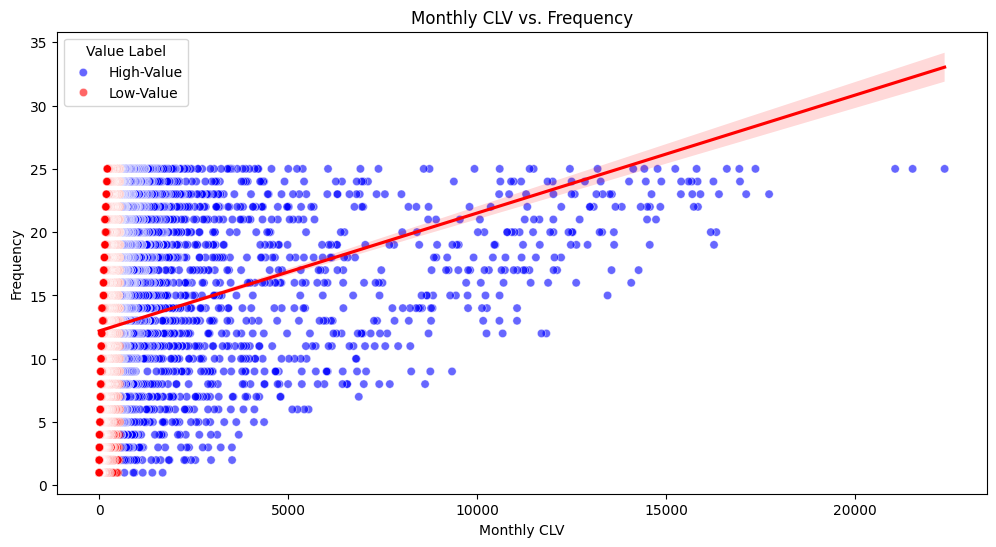

In [64]:
# Scatter plot: Frequency vs. Monthly CLV
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_df, x='clv_monthly', y='frequency', hue='value_label', palette=['red', 'blue'], alpha=0.6)
sns.regplot(data=merged_df, x='clv_monthly', y='frequency', scatter=False, color='red')
plt.title('Monthly CLV vs. Frequency')
plt.xlabel('Monthly CLV')
plt.ylabel('Frequency')
plt.legend(title='Value Label', labels=['High-Value', 'Low-Value'])
plt.show()

# Scatter plot: Recency Months vs. Monthly CLV
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_df, x='recency_months', y='clv_monthly', hue='value_label', palette=['red', 'blue'], alpha=0.6)
sns.regplot(data=merged_df, x='recency_months', y='clv_monthly', scatter=False, color='red')
plt.title('Recency Months vs. Monthly CLV')
plt.xlabel('recency_months')
plt.ylabel('Monthly CLV')
plt.legend(title='Value Label', labels=['High-Value', 'Low-Value'])
plt.show()

In [65]:
#scatter plots of marketing data and promotion data

# Scatter plot: Number of Site Visits per Month vs. CLV
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_df[merged_df['value_label'] == 0], x='site_visits_per_month', y='clv', color='red', alpha=0.6, label='Low Value')
sns.scatterplot(data=merged_df[merged_df['value_label'] == 1], x='site_visits_per_month', y='clv', color='blue', alpha=0.6, label='High Value')
plt.title('Number of Site Visits per Month vs. CLV')
plt.xlabel('Number of Site Visits per Month')
plt.ylabel('CLV')
plt.legend()
plt.show()

# Scatter plot: Number of Emails Opened per Month vs. CLV
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_df[merged_df['value_label'] == 0], x='emails_opened_per_month', y='clv', color='red', alpha=0.6, label='Low Value')
sns.scatterplot(data=merged_df[merged_df['value_label'] == 1], x='emails_opened_per_month', y='clv', color='blue', alpha=0.6, label='High Value')
plt.title('Number of Emails Opened per Month vs.CLV')
plt.xlabel('Number of Emails Opened per Month')
plt.ylabel('CLV')
plt.legend()
plt.show()

# Scatter plot: Number of Clicks per Month vs. CLV
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_df[merged_df['value_label'] == 0], x='clicks_per_month', y='clv', color='red', alpha=0.6, label='Low Value')
sns.scatterplot(data=merged_df[merged_df['value_label'] == 1], x='clicks_per_month', y='clv', color='blue', alpha=0.6, label='High Value')
plt.title('Number of Clicks per Month vs. CLV')
plt.xlabel('Number of Clicks per Month')
plt.ylabel('CLV')
plt.legend()
plt.show()

# Scatter plot: Number of Emails Opened vs. Number of Clicks
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_df, x='number_of_emails_opened', y='number_of_clicks', color='red', alpha=0.6)
sns.regplot(data=merged_df, x='number_of_emails_opened', y='number_of_clicks', scatter=False, color='blue')
sns.scatterplot(data=merged_df[merged_df['value_label'] == 0], x='number_of_emails_opened', y='number_of_clicks', color='red', alpha=0.6, label='Low Value')
sns.scatterplot(data=merged_df[merged_df['value_label'] == 1], x='number_of_emails_opened', y='number_of_clicks', color='blue', alpha=0.6, label='High Value')
plt.title('Number of Emails Opened vs. Number of Clicks')
plt.xlabel('Number of Emails Opened')
plt.ylabel('Number of Clicks')
plt.show()

# Scatter plot: Number of Clicks vs. Yes Response
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_df[merged_df['value_label'] == 0], x='number_of_clicks', y='yes_response', color='red', alpha=0.6, label='Low Value')
sns.scatterplot(data=merged_df[merged_df['value_label'] == 1], x='number_of_clicks', y='yes_response', color='blue', alpha=0.6, label='High Value')
plt.title('Number of Clicks vs. Yes Response')
plt.xlabel('Number of Clicks')
plt.ylabel('Yes Response')
plt.legend()
plt.show()

In [66]:
# EDA response type
# Filter high value and low value customers
high_value_customers = merged_df[merged_df['value_label'] == 1]['customer_id']
low_value_customers = merged_df[merged_df['value_label'] == 0]['customer_id']

# Filter marketing data for high value and low value customers
high_value_marketing = marketing_df[marketing_df['customer_id'].isin(high_value_customers) & (marketing_df['response'] == 'Yes')]
low_value_marketing = marketing_df[marketing_df['customer_id'].isin(low_value_customers) & (marketing_df['response'] == 'Yes')]

# Count positive responses for each promotion type
high_value_promotion_counts = high_value_marketing['promotion_type'].value_counts()
low_value_promotion_counts = low_value_marketing['promotion_type'].value_counts()

# Plot pie chart for high value customers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
high_value_promotion_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('High Value Customers - Positive Responses by Promotion Type')
plt.ylabel('')

# Plot pie chart for low value customers
plt.subplot(1, 2, 2)
low_value_promotion_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Low Value Customers - Positive Responses by Promotion Type')
plt.ylabel('')

plt.tight_layout()
plt.show()

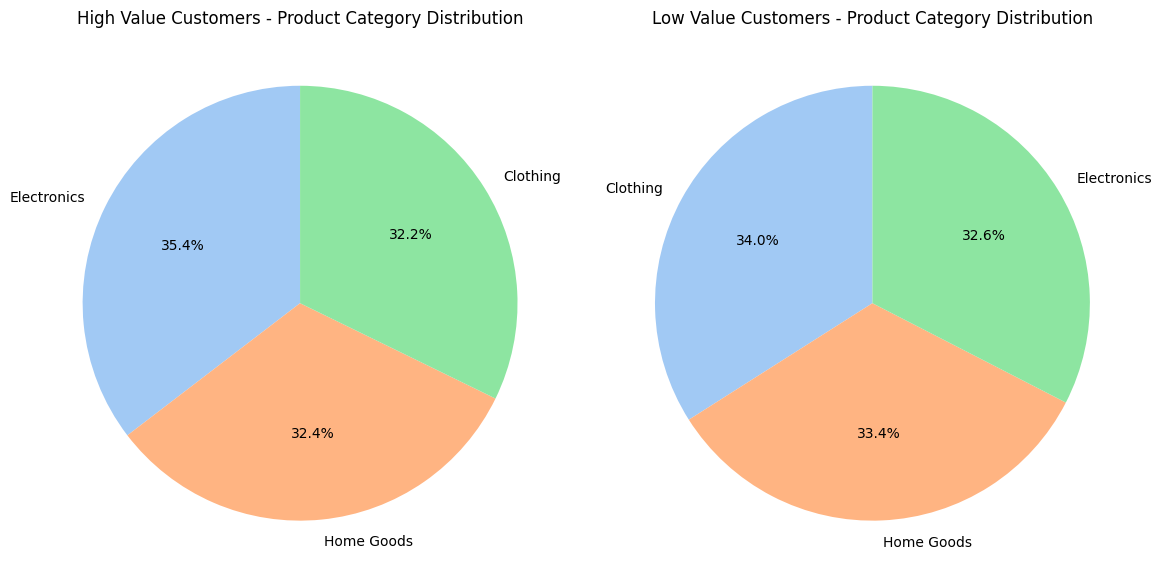

In [67]:
# Promotion type analysis
# Filter high value and low value customers
high_value_customers = merged_df[merged_df['value_label'] == 1]['customer_id']
low_value_customers = merged_df[merged_df['value_label'] == 0]['customer_id']

# Filter transaction data for high value and low value customers
high_value_transactions = transactions_df[transactions_df['customer_id'].isin(high_value_customers)]
low_value_transactions = transactions_df[transactions_df['customer_id'].isin(low_value_customers)]

# Count product categories for each customer group
high_value_product_counts = high_value_transactions['product_category'].value_counts()
low_value_product_counts = low_value_transactions['product_category'].value_counts()

# Plot pie chart for high value customers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
high_value_product_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('High Value Customers - Product Category Distribution')
plt.ylabel('')

# Plot pie chart for low value customers
plt.subplot(1, 2, 2)
low_value_product_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Low Value Customers - Product Category Distribution')
plt.ylabel('')

plt.tight_layout()
plt.show()

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Include only numeric features and the target variable
numeric_features = ['age', 'recency_months', 'frequency', 'yes_response_per_month', 
                    'site_visits_per_month', 
                    'emails_opened_per_month', 'clicks_per_month', 'clv_monthly']

# Create a pairplot
sns.pairplot(merged_df, vars=numeric_features, hue='value_label', palette='coolwarm', diag_kind='kde')

# Display the plot
plt.show()

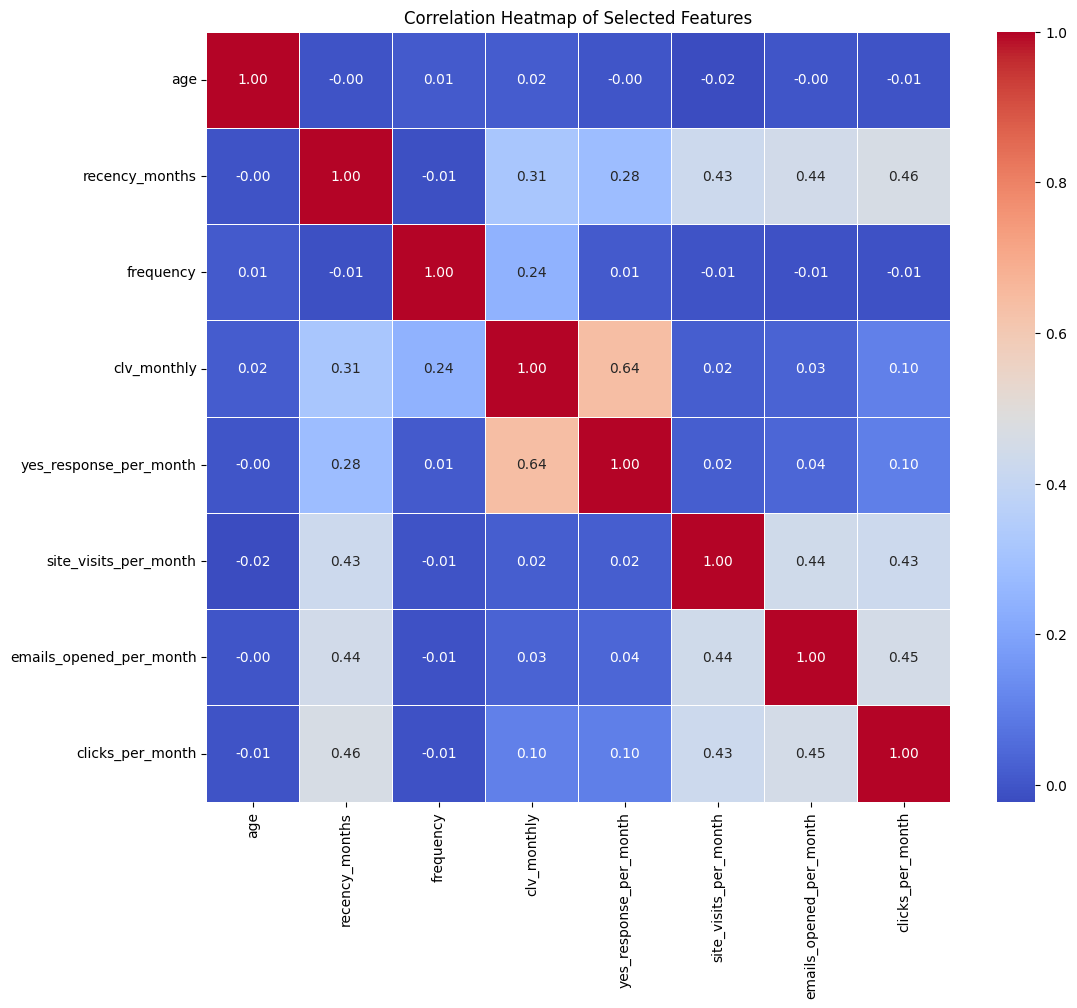

In [69]:
#run a py-plot
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'merged_df'
# Include only numeric features and the target variable
numeric_features = ['age', 'recency_months', 'frequency', 'clv_monthly', 'yes_response_per_month', 
                    'site_visits_per_month', 
                    'emails_opened_per_month', 'clicks_per_month']

# Calculate the correlation matrix
corr_matrix = merged_df[numeric_features].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Selected Features')
plt.show()
